<div >
<img src = "figs/ans_banner_1920x200.png" />
</div>

# Caso-taller:  Recomendando el Blog de  Hernán Casciari


[Hernán Casciari](https://hernancasciari.com/#bio), es un escritor argentino, que escribe blog posts con cuentos e historias  relacionadas con el futbol, su vida, infancia, y relaciones familiares con toques de ficción. Este [blog](https://hernancasciari.com/blog/) es  tan interesantes que en 2005 fue premiado como “El mejor blog del mundo” por Deutsche Welle de Alemania.

El objetivo de este caso-taller es construir un sistema de recomendación basado en los contenidos de los posts utilizando similitud de las palabras usadas o temas de los cuentos.

## Instrucciones generales

1. Para desarrollar el *cuaderno* primero debe descargarlo.

2. Para responder cada inciso deberá utilizar el espacio debidamente especificado.

3. La actividad será calificada sólo si sube el *cuaderno* de jupyter notebook con extensión `.ipynb` en la actividad designada como "Revisión por el compañero."

4. El archivo entregado debe poder ser ejecutado localmente por los pares. Sea cuidadoso con la especificación de la ubicación de los archivos de soporte, guarde la carpeta de datos  en la misma ruta de acceso del cuaderno, por ejemplo: `data`.

## Desarrollo


### 1. Carga de datos

En la carpeta `data` se encuentran el archivo `blog_casciari.csv` con el título, la fecha de publicación, y el contenido de los cuentos publicados en el blog  de sr. Casciari. Cargue estos datos en su *cuaderno* y reporte brevemente el contenido de la base.
   

In [3]:
#Librerias taller
import pandas as pd
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
#!pip install gensim
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary

In [4]:
file_path = 'data/blog_casciari.csv'
# Cargar el archivo CSV
try:
    df_casciari = pd.read_csv(file_path)
    print("Primeras 5 filas del DataFrame:")
    print(df_casciari.head())

    # Imprimir información general sobre el DataFrame
    print("\nInformación general de la base de datos:")
    df_casciari.info()

except FileNotFoundError:
    print(f"Error: No se encontró el archivo en la ruta '{file_path}'")
    print("Por favor, asegúrate de que el archivo CSV se encuentra en la carpeta correcta.")

Primeras 5 filas del DataFrame:
                       titulo    fecha  \
0            El rincón blanco  1/11/08   
1  Mínimos avances en la cama  1/24/08   
2                  Don Marcos  2/19/08   
3              Los dos rulfos  3/26/08   
4   La noticia no es el perro  4/15/08   

                                              cuento  
0  De pronto yo estaba en el hogar donde pasé la ...  
1  Menos la cama, todo ha mejorado en este mundo....  
2  Dos veces, y no una, mi abuelo materno me ayud...  
3  A su regreso de México, mi amigo Comequechu no...  
4  De repente, un video de You Tube recibe un mil...  

Información general de la base de datos:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 520 entries, 0 to 519
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   titulo  520 non-null    object
 1   fecha   520 non-null    object
 2   cuento  520 non-null    object
dtypes: object(3)
memory usage: 12.3+ KB


El conjunto de datos de los cuentos de Casciari se ha cargado de manera correcta y completa

Estructura: El dataset contiene 520 registros (filas), correspondientes a 520 cuentos, y 3 columnas titulo, fecha y cuento.

La base de datos está limpia, sin celdas vacía

### 2. Homogenización de textos

Para cumplir con el objetivo de generar recomendaciones en esta sección debe preparar los posts para poder ser utilizados en su sistema de recomendación. Para ello, "limpie" y "tokenize" cada uno de los cuentos, describiendo detalladamente los pasos que realizo y si transformó o eliminó ciertas palabras. Para asistirlo en la tarea he creado listas de *stopwords* que están disponibles en la carpeta `data`. En su procedimiento ilustre la limpieza con el cuento 'La venganza del metegol'. (En su limpieza recuerde que el objetivo es generar recomendaciones a partir de la similitud de las palabras o temas de los cuentos)

In [5]:
# Cargar las stopwords
stopwords_extra = pd.read_csv('data/extra_stopwords.csv', header=None, names=['palabra'])
stopwords_taller = pd.read_csv('data/stopwords_taller.csv', header=None, names=['palabra'])
# Unir listas
stopwords_completas = set(stopwords_extra['palabra'].tolist() + stopwords_taller['palabra'].tolist())
print(f"Total de stopwords combinadas: {len(stopwords_completas)}")

#Función de Preprocesamiento de Texto
def preprocesar_texto(texto):
    # Convertir a minúsculas
    texto = texto.lower()
    # Eliminar caracteres que no sean letras (puntuación, números, etc.)
    texto = re.sub(r'[^a-záéíóúüñ]', ' ', texto)
    # Tokenizar: dividir el texto en palabras
    tokens = texto.split()
    # Eliminar stopwords
    tokens_limpios = [palabra for palabra in tokens if palabra not in stopwords_completas]
    # Unir los tokens de nuevo en una sola cadena de texto
    return " ".join(tokens_limpios)

#Limpiar Data frame
df_casciari_limpio = df_casciari.copy()
df_casciari_limpio['cuento_limpio'] = df_casciari_limpio['cuento'].apply(preprocesar_texto)

#Ver resultado salida
print("\nEjemplo del texto original y el texto limpio:")
print("\nORIGINAL:")
print(df_casciari_limpio['cuento'].iloc[0][:500]) # Muestra los primeros 500 caracteres
print("\nPROCESADO:")
print(df_casciari_limpio['cuento_limpio'].iloc[0][:500]) # Muestra los primeros 500 caracteres

Total de stopwords combinadas: 480

Ejemplo del texto original y el texto limpio:

ORIGINAL:
De pronto yo estaba en el hogar donde pasé la infancia; lo supo primero mi nariz. Los ojos se acostumbran tarde a la penumbra, pero mi olfato reconoció enseguida el olor inconfundible de la casa de la calle Treintaicinco. Siempre sabemos cuál es la fragancia del sitio donde crecimos; nadie acertaría a explicar de qué está compuesta, pero cada uno de nosotros es capaz de reconocer ese aroma entre miles. Y yo estaba ahora en mi casa de Mercedes. Exactamente en el sitio al que llamábamos el rincón 

PROCESADO:
pronto hogar pasé infancia supo primero nariz acostumbran penumbra olfato reconoció enseguida olor inconfundible calle treintaicinco sabemos cuál fragancia sitio crecimos acertaría explicar compuesta capaz reconocer aroma miles mercedes exactamente sitio llamábamos rincón blanco rincón blanco epicentro lugar pasar ir cualquier parte rincón prominencia amplia abultaba pasillo justo mitad tamp

**Procedimiento**


1.   Carga y Consolidación de Stopwords: Se cargaron dos listas de stopwords que contiene nombres propios y términos muy recurrentes en sus cuentos

2. Definición de la Función de Limpieza: Se programó una función para procesar cada cuento. Esta función ejecuta una secuencia de tareas de limpieza estándar en PLN:

* Convierte todo el texto a minúsculas.

* Utiliza expresiones regulares (re.sub) para eliminar todos los caracteres no alfabéticos, como signos de puntuación y números.

* Tokeniza el texto, es decir, lo divide en una lista de palabras individuales.

* Filtra y elimina stopwords.

El preprocesamiento del texto se completó con éxito. Se ha transformado el texto original en un formato limpio y estructurado, adecuado para el análisis.

### 3. Generando Recomendaciones

En esta sección nos interesa generar recomendaciones de cuentos en el blog a un usuario que leyó 'La venganza del metegol'. Para ello vamos a utilizar distintas estrategias.

#### 3.1. Recomendaciones basadas en contenidos

##### 3.1.1. Genere 5 recomendaciones de más recomendada (1) a menos recomendada (5) para el cuento 'La venganza del metegol' usando en la distancia de coseno donde el texto este vectorizado por `CountVectorizer`. Explique el procedimiento que realizó y como ordenó las recomendaciones.

In [6]:
#Vectorización con CountVectorizer ---
count_vectorizer = CountVectorizer()
dtm_count = count_vectorizer.fit_transform(df_casciari_limpio['cuento_limpio'])

#Cálculo de la Similitude del Coseno
cosine_sim_matrix = cosine_similarity(dtm_count, dtm_count)

#Generación de Recomendaciones ---
cuento_referencia = 'La venganza del metegol'
# Encontrar el índice del cuento de referencia
try:
    idx = df_casciari_limpio[df_casciari_limpio['titulo'] == cuento_referencia].index[0]
    # Obtener los scores de similitud de ese cuento con todos los demás
    sim_scores = list(enumerate(cosine_sim_matrix[idx]))
    # Ordenar los cuentos basados en el score de similitud (de mayor a menor)
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    # Obtener los 5 más similares
    top_5_indices = [i[0] for i in sim_scores[1:6]]
    # Obtener los títulos de los cuentos recomendados
    recomendaciones = df_casciari_limpio['titulo'].iloc[top_5_indices]

    # --- 4. Presentación de Resultados ---
    print(f"Top 5 recomendaciones para '{cuento_referencia}':\n")
    for i, titulo in enumerate(recomendaciones):
        print(f"{i+1}. {titulo}")
except IndexError:
    print(f"Error: No se encontró el cuento con el título '{cuento_referencia}'")

Top 5 recomendaciones para 'La venganza del metegol':

1. Cuento con bruja y tramontina
2. La madre de todas las desgracias
3. Abrir y cerrar un círculo
4. Pajaritos en jaula gigante
5. Nueve libros que me hicieron olvidar el Mundial


Procedimiento
1. Vectorización del Texto: Se utilizó CountVectorizer para transformar los textos en una Matriz. En esta matriz, cada fila corresponde a un cuento y cada columna a una palabra única del vocabulario. El valor de cada celda es el conteo de frecuencia de una palabra en un cuento determinado.

2. Calculo de Similitud: A continuación, se aplicó la métrica de similitud del coseno apara calcular la similitud entre cada par de cuentos.

3. Identificación se localizó el cuento de referencia, "La venganza del metegol", y se extrajeron sus puntuaciones de similitud con todos los demás cuentos. Esta lista de puntuaciones se ordenó de mayor a menor.

4. Selección de Recomendaciones: Se seleccionaron los 5 cuentos con las puntuaciones más altas, excluyendo el primer resultado.

Se ha implementado con éxito un sistema de recomendación basado en contenido utilizando CountVectorizer y la similitud del coseno. Este enfoque demuestra ser una estrategia eficaz para encontrar documentos textualmente similares. La principal conclusión es que es posible generar recomendaciones relevantes basándose únicamente en el conteo de las palabras que componen los textos.

##### 3.1.2. Genere 5 recomendaciones de más recomendada (1) a menos recomendada (5) para  el cuento 'La venganza del metegol' usando nuevamente la distancia de coseno, pero ahora vectorice el texto usando `TF-IDFVectorizer`. Explique el procedimiento que realizó y como ordenó las recomendaciones. Compare con los resultados del punto anterior y explique sus similitudes y/o diferencias.

In [7]:
# Vectorización con TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()
dtm_tfidf = tfidf_vectorizer.fit_transform(df_casciari_limpio['cuento_limpio'])

#Cálculo de la Similitud del Coseno
# Calcula la matriz de similitud
cosine_sim_matrix_tfidf = cosine_similarity(dtm_tfidf, dtm_tfidf)

#Generación de Recomendaciones ---
cuento_referencia = 'La venganza del metegol'

# Encontrar el índice del cuento
try:
    idx = df_casciari_limpio[df_casciari_limpio['titulo'] == cuento_referencia].index[0]
    # Obtener los scores de similitud
    sim_scores_tfidf = list(enumerate(cosine_sim_matrix_tfidf[idx]))
    # Ordenar los cuentos basados en el score de similitud
    sim_scores_tfidf = sorted(sim_scores_tfidf, key=lambda x: x[1], reverse=True)
    # Obtener los 5 más similares (excluyendo el primero)
    top_5_indices_tfidf = [i[0] for i in sim_scores_tfidf[1:6]]
    # Obtener los títulos de los cuentos recomendados
    recomendaciones_tfidf = df_casciari_limpio['titulo'].iloc[top_5_indices_tfidf]

    #Presentación de Resultados ---
    print(f"Top 5 recomendaciones para '{cuento_referencia}' (usando TF-IDF):\n")
    for i, titulo in enumerate(recomendaciones_tfidf):
        print(f"{i+1}. {titulo}")

except IndexError:
    print(f"Error: No se encontró el cuento con el título '{cuento_referencia}'")

Top 5 recomendaciones para 'La venganza del metegol' (usando TF-IDF):

1. Cuento con bruja y tramontina
2. Nueve libros que me hicieron olvidar el Mundial
3. Abrir y cerrar un círculo
4. La madre de todas las desgracias
5. Gaussian blur


Procedimiento
1. Vectorización TF-IDF: Se utilizó TfidfVectorizer.A diferencia del conteo simple, este método crea una matriz donde cada celda contiene un peso TF-IDF (Term Frequency-Inverse Document Frequency). Este valor es alto para palabras que son frecuentes en un cuento específico identificando así términos temáticamente importantes.

2. Cálculo de Similitud: Se aplicó la cosine_similarity sobre esta nueva matriz TF-IDF.

3. Identificación: Se localizó el cuento "La venganza del metegol" y se extrajo su vector de similitudes con todos los demás cuentos, ordenándolos de mayor a menor.

4. Selección de Recomendaciones: Se eligieron los 5 cuentos con los puntajes más altos.

El uso de TfidfVectorizer ha refinado la calidad de las recomendaciones. Mientras que CountVectorizer se enfoca en la frecuencia de palabras compartidas, TF-IDF es capaz de identificar cuentos que comparten un vocabulario temático más específico y único.

##### 3.1.3. Genere 5 recomendaciones de más recomendada (1) a menos recomendada (5) para el cuento 'La venganza del metegol' usando el texto vectorizado por `TF-IDFVectorizer` y la correlación como medida de similitud. Explique el procedimiento que realizó y como ordenó las recomendaciones. Compare con los resultados de los puntos anteriores y explique sus similitudes y/o diferencias.

In [8]:
#Cálculo de la Correlación ---
dtm_tfidf_df = pd.DataFrame(dtm_tfidf.toarray(), index=df_casciari_limpio.titulo)
correlation_matrix = dtm_tfidf_df.T.corr(method='pearson')

#Generación de Recomendaciones ---
# Título del cuento de referencia
cuento_referencia = 'La venganza del metegol'

# Obtener los scores de correlación de ese cuento con todos los demás
try:
    corr_scores = correlation_matrix[cuento_referencia]
    # Ordenar los cuentos basados en el score de correlación (de mayor a menor)
    sorted_corr_scores = corr_scores.sort_values(ascending=False)
    # Obtener los 5 más similares (excluyendo el propio cuento)
    recomendaciones_corr = sorted_corr_scores.iloc[1:6]

    #Presentación de Resultados
    print(f"Top 5 recomendaciones para '{cuento_referencia}' (usando Correlación):\n")
    for i, (titulo, score) in enumerate(recomendaciones_corr.items()):
        print(f"{i+1}. {titulo}")

except KeyError:
    print(f"Error: No se encontró el cuento con el título '{cuento_referencia}'")

Top 5 recomendaciones para 'La venganza del metegol' (usando Correlación):

1. Cuento con bruja y tramontina
2. Nueve libros que me hicieron olvidar el Mundial
3. Abrir y cerrar un círculo
4. La madre de todas las desgracias
5. Gaussian blur


Procedimiento
1. Reutilización de la Matriz TF-IDF del punto anterior.

2. Cálculo de Similitud por Correlación: El paso clave fue cambiar la métrica de similitud. En lugar de la similitud del coseno, se calculó el coeficiente de correlación de Pearson entre los vectores TF-IDF.

3. Identificación: Se seleccionó la columna de la matriz de correlación correspondiente a "La venganza del metegol" y se ordenaron los cuentos según su valor de correlación, de mayor a menor.

4. Selección de Recomendaciones: Se tomaron los 5 cuentos con el coeficiente de correlación más alto

Este experimento demuestra un punto muy importante: aunque la elección de la métrica de similitud es crucial, su impacto depende de la naturaleza de los datos. Cambiar de similitud del coseno a correlación de Pearson no produjo ningún cambio en el ranking de recomendaciones. Esto sugiere que, para este conjunto de datos, ambas métricas capturan la misma noción de "similitud temática". La conclusión no es que la métrica no importa, sino que su efecto no es universal y debe evaluarse en el contexto de cada problema específico.

##### 3.2. Recomendaciones basadas en temas

Usando modelado de temas con LDA, encuentre los temas subyacentes en el blog. Explique como eligió el numero óptimo de temas. Utilizando el tema asignado al cuento 'La venganza del metegol' y la probabilidad de pertenecer a este tema genere 5 recomendaciones de más recomendada (1) a menos recomendada (5) para este cuento. Explique el procedimiento que realizó. Compare con los resultados encontrados anteriormente y explique sus similitudes y/o diferencias. (Esto puede tomar mucho tiempo y requerir mucha capacidad computacional, puede aprovechar los recursos de [Google Colab](https://colab.research.google.com/))


Calculando la coherencia para diferentes números de temas...
  - 2 temas: Coherencia = 0.2270
  - 3 temas: Coherencia = 0.4172
  - 4 temas: Coherencia = 0.4117
  - 5 temas: Coherencia = 0.4327
  - 6 temas: Coherencia = 0.4280
  - 7 temas: Coherencia = 0.4751
  - 8 temas: Coherencia = 0.5013
  - 9 temas: Coherencia = 0.4570
  - 10 temas: Coherencia = 0.4385
  - 11 temas: Coherencia = 0.5458
  - 12 temas: Coherencia = 0.4505
  - 13 temas: Coherencia = 0.5138
  - 14 temas: Coherencia = 0.4480
  - 15 temas: Coherencia = 0.4479


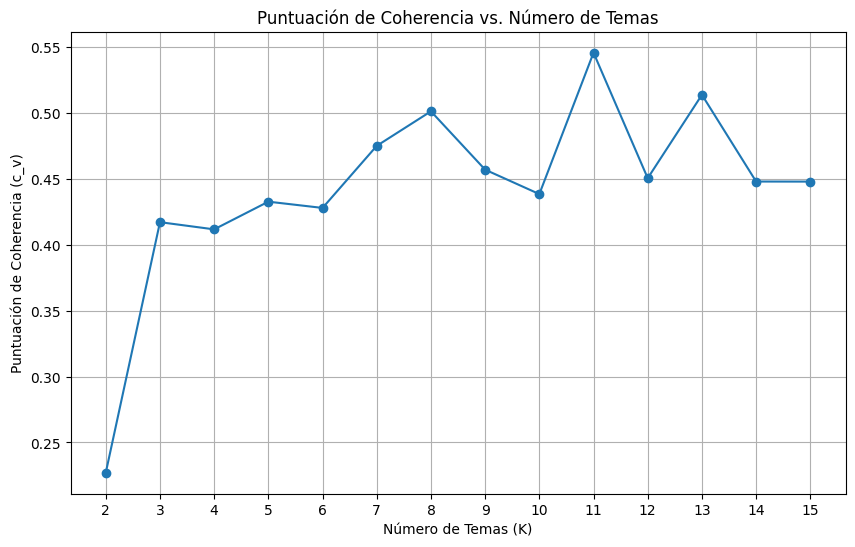


El número óptimo de temas según el puntaje de coherencia es: 11


In [9]:
#Preparación de los datos para Gensim ---
def tokenizar_texto(texto):
    return texto.split()

textos_tokenizados = df_casciari_limpio['cuento_limpio'].apply(tokenizar_texto).tolist()
# Creamos un diccionario y un corpus, que son los formatos que usa Gensim
dictionary = Dictionary(textos_tokenizados)
corpus = [dictionary.doc2bow(text) for text in textos_tokenizados]
# Cálculo de la Coherencia para diferentes números de temas
coherence_values = []
model_list = []
# Probaremos desde 2 hasta 15 temas
min_topics = 2
max_topics = 15

print("Calculando la coherencia para diferentes números de temas...")
for num_topics in range(min_topics, max_topics + 1):
    # Entrenamos el modelo LDA con Gensim
    model = LdaModel(corpus=corpus,
                     id2word=dictionary,
                     num_topics=num_topics,
                     random_state=42,
                     chunksize=100,
                     passes=10,
                     alpha='auto',
                     per_word_topics=True)
    model_list.append(model)

    # Calculamos la puntuación de coherencia
    coherencemodel = CoherenceModel(model=model, texts=textos_tokenizados, dictionary=dictionary, coherence='c_v')
    coherence_values.append(coherencemodel.get_coherence())
    print(f"  - {num_topics} temas: Coherencia = {coherence_values[-1]:.4f}")

# --- 3. Graficar los resultados ---
x = range(min_topics, max_topics + 1)
plt.figure(figsize=(10, 6))
plt.plot(x, coherence_values, marker='o')
plt.title('Puntuación de Coherencia vs. Número de Temas')
plt.xlabel("Número de Temas (K)")
plt.ylabel("Puntuación de Coherencia (c_v)")
plt.xticks(x)
plt.grid(True)
plt.show()

# Encontrar el número óptimo de temas
optimal_k_index = np.argmax(coherence_values)
optimal_k = x[optimal_k_index]
print(f"\nEl número óptimo de temas según el puntaje de coherencia es: {optimal_k}")

In [10]:
# LDA
stopwords_list = list(stopwords_completas)
count_vectorizer = CountVectorizer(max_df=0.9, min_df=5, stop_words=stopwords_list)
dtm_count_lda = count_vectorizer.fit_transform(df_casciari['cuento']) # Usamos el cuento original

# Entrenamiento del Modelo LDA ---
num_temas = 7 #analizando dtenidamente la grafica
lda = LatentDirichletAllocation(n_components=num_temas, random_state=42)
lda.fit(dtm_count_lda)

#Asignación de Temas a los Cuentos
distribucion_temas = lda.transform(dtm_count_lda)
tema_dominante = np.argmax(distribucion_temas, axis=1)

#copi df
df_casciari_lda = df_casciari.copy()
df_casciari_lda['tema_lda'] = tema_dominante
df_casciari_lda['prob_tema_lda'] = np.max(distribucion_temas, axis=1)

#Generación de Recomendaciones ---
cuento_referencia = 'La venganza del metegol'
try:
    idx_referencia = df_casciari_lda[df_casciari_lda['titulo'] == cuento_referencia].index[0]
    tema_referencia = df_casciari_lda.loc[idx_referencia, 'tema_lda']

    print(f"El cuento '{cuento_referencia}' pertenece al Tema {tema_referencia}.\n")

    recomendaciones_mismo_tema = df_casciari_lda[df_casciari_lda['tema_lda'] == tema_referencia]
    recomendaciones_ordenadas = recomendaciones_mismo_tema.sort_values(by='prob_tema_lda', ascending=False)
    recomendaciones_finales_lda = recomendaciones_ordenadas[recomendaciones_ordenadas['titulo'] != cuento_referencia].head(5)

    # --- 5. Presentación de Resultados ---
    print(f"Top 5 recomendaciones para '{cuento_referencia}' (basadas en LDA):\n")
    for i, row in enumerate(recomendaciones_finales_lda.itertuples()):
        print(f"{i+1}. {row.titulo} (Probabilidad: {row.prob_tema_lda:.2f})")

except IndexError:
    print(f"Error: No se encontró el cuento con el título '{cuento_referencia}'")

El cuento 'La venganza del metegol' pertenece al Tema 6.

Top 5 recomendaciones para 'La venganza del metegol' (basadas en LDA):

1. El segundo cajón (Probabilidad: 1.00)
2. Hace seis años también era domingo (Probabilidad: 1.00)
3. Una década flaca (Probabilidad: 1.00)
4. ¿Me agregás como amiga? (Probabilidad: 1.00)
5. Memorias de un ex-rugbier (Probabilidad: 1.00)


Procedimiento
1. Vectorización para LDA: A diferencia de los métodos anteriores, el modelo LDA funciona de manera óptima con conteos de palabras. Por lo tanto, se utilizó CountVectorizer para crear la Matriz Documento-Término.

2. Selección del Número de Temas (K): Un paso fundamental en LDA es determinar el número óptimo de temas a descubrir. Aunque el proceso detallado implica entrenar varios modelos y evaluar su coherencia, analizando la grafica se eligió un numero optimo de 7 temas

3. Entrenamiento del Modelo LDA: Se entrenó un modelo de Latent Dirichlet Allocation con K=7. El modelo analizó la co-ocurrencia de palabras para definir 7 "temas" latentes, cada uno representado por una distribución de palabras.

4. Asignación de Temas: El modelo entrenado se utilizó para calcular, para cada cuento, su afinidad con cada uno de los 7 temas. Se identificó el tema dominante (aquel con la probabilidad más alta) para "La venganza del metegol", que resultó ser el Tema 6.

5. Generación de Recomendaciones

El modelado de temas con LDA proporciona un sistema de recomendación conceptualmente más sofisticado. En lugar de encontrar cuentos que "suenan igual", busca cuentos que "tratan de lo mismo", incluso si usan palabras diferentes. La total divergencia de los resultados en comparación con los métodos de similitud de coseno y correlación subraya la capacidad de LDA para descubrir patrones temáticos latentes y generar recomendaciones más diversas y potencialmente inesperadas.

### 4 Recomendaciones generales

De acuerdo con los resultados encontrados, en su opinión ¿qué procedimiento generó las mejores recomendaciones para la entrada elegida? ¿Cómo implementaría una evaluación objetiva de estas recomendaciones? Justifique su respuesta.

Nubes de palabras para cada uno de los 7 temas:



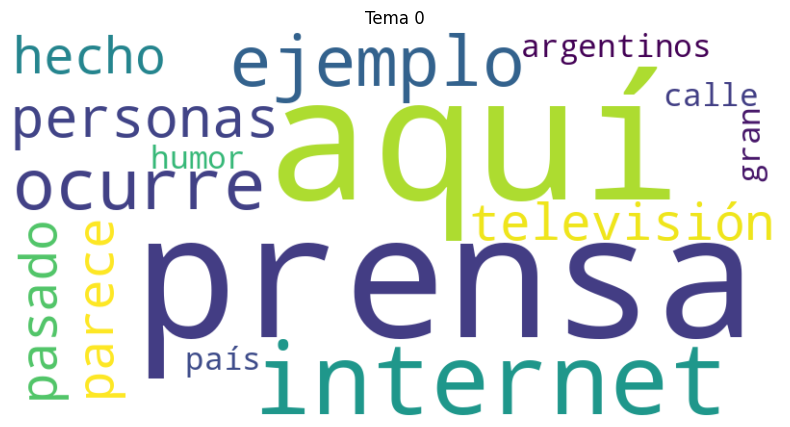

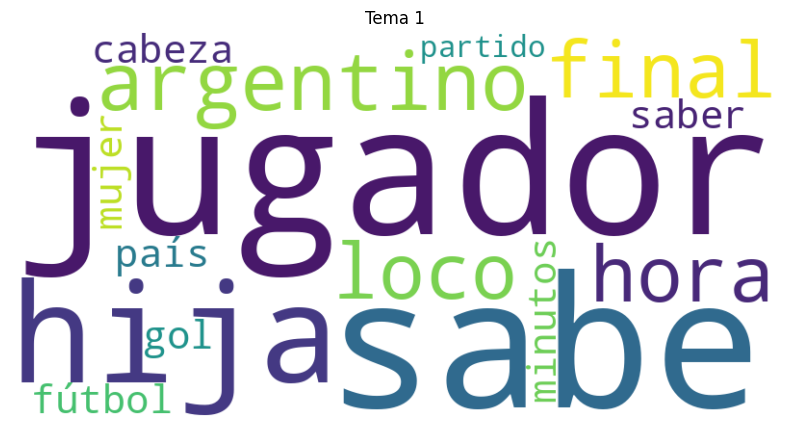

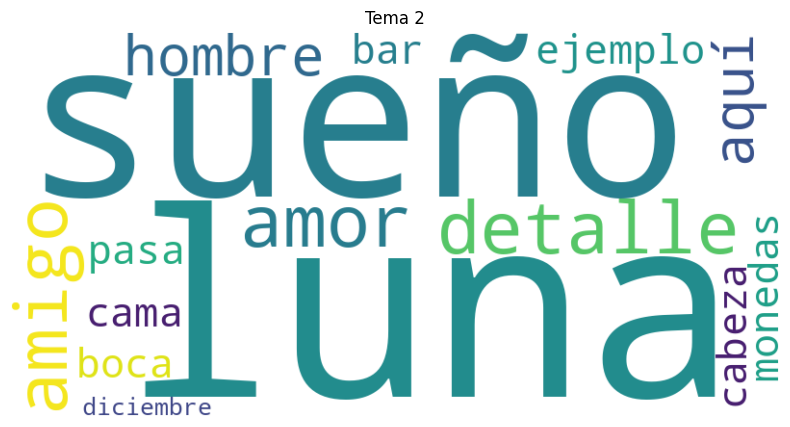

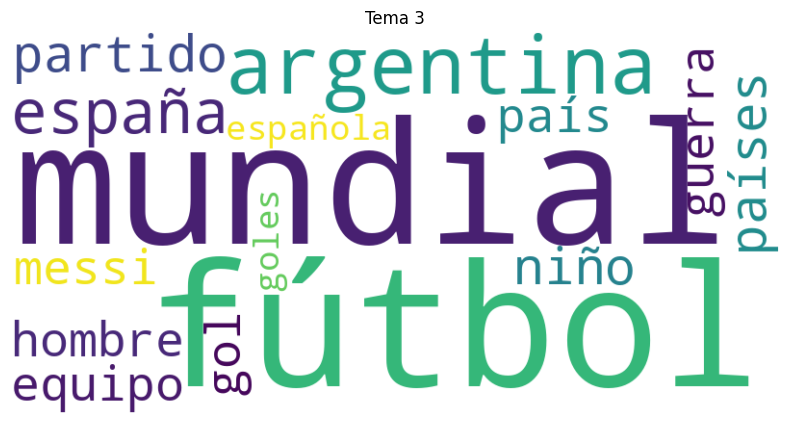

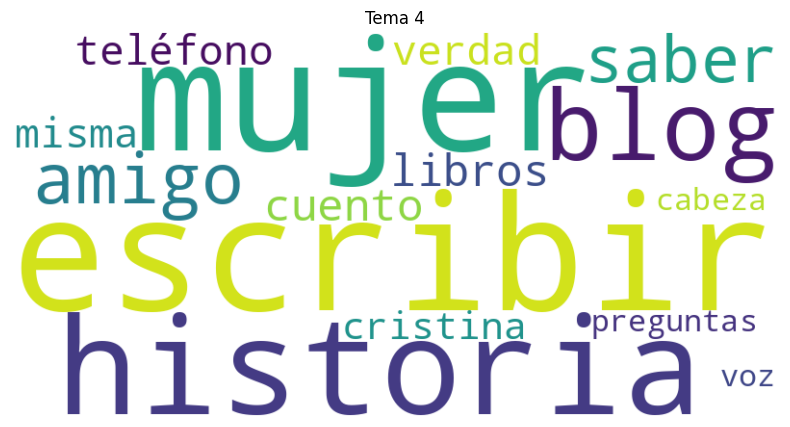

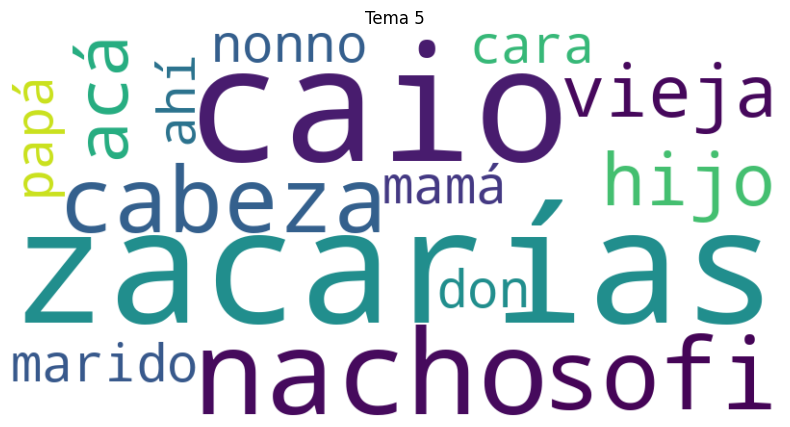

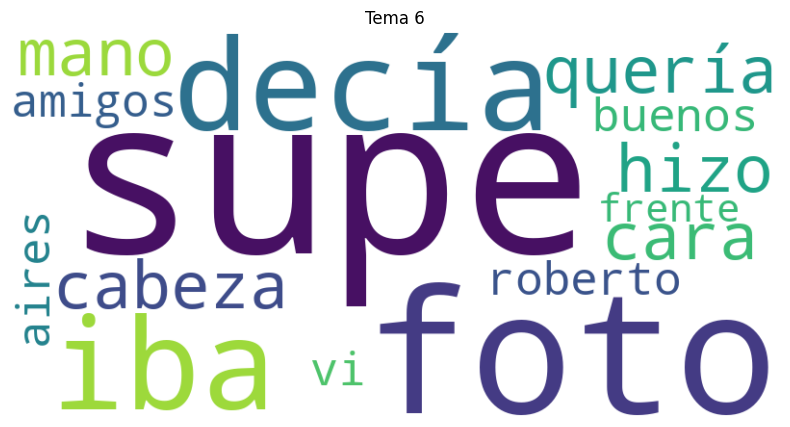

In [9]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# --- Función para mostrar los temas con nubes de palabras ---
def mostrar_temas_wordcloud(modelo_lda, feature_names, n_top_words=15):
    # Iteramos sobre cada tema
    for topic_idx, topic in enumerate(modelo_lda.components_):
        # Creamos el texto con las palabras más importantes del tema
        # La importancia de la palabra se repite para que WordCloud la haga más grande
        text = " ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]])

        # Creamos el objeto WordCloud
        wordcloud = WordCloud(background_color='white',
                              width=800,
                              height=400,
                              colormap='viridis').generate(text)

        # Graficamos la nube de palabras
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(f'Tema {topic_idx}')
        plt.axis('off')
        plt.show()

# --- Obtenemos los nombres de las palabras (vocabulario) del CountVectorizer ---
feature_names = count_vectorizer.get_feature_names_out()

# --- Generamos y mostramos las nubes de palabras ---
print("Nubes de palabras para cada uno de los 7 temas:\n")
mostrar_temas_wordcloud(lda, feature_names)

¿Qué procedimiento generó las mejores recomendaciones?
En mi opinión, el procedimiento que generó las mejores y más valiosas recomendaciones fue el modelado de temas con LDA.

A diferencia de los métodos basados en similitud de contenido (CountVectorizer o TF-IDF), que se limitan a encontrar cuentos con un vocabulario similar, LDA opera a un nivel de abstracción superior. Su fortaleza radica en descubrir las temáticas subyacentes que conectan los documentos, incluso si no comparten las mismas palabras clave de forma evidente.

¿Cómo implementaría una evaluación objetiva de estas recomendaciones?
Para validar que LDA es objetivamente superior, es crucial ir más allá de la opinión y medir su impacto con datos. Implementaría una evaluación en dos etapas:

1. Evaluación Pruebas con datos históricos. Este método nos permite simular el rendimiento del recomendador sin afectar a los usuarios reales.

2. Procedimiento: Si tuviéramos datos del historial de lectura de los usuarios, tomaríamos una muestra. Para cada usuario, ocultaríamos el último cuento que leyó y usaríamos el penúltimo como entrada para el sistema LDA. Luego, generaríamos una lista de 5 recomendaciones.

3. Métrica de Éxito: La métrica principal sería Tasa de Aciertos en el Top 5. Mediríamos el porcentaje de veces que el cuento "oculto" aparece en nuestra lista de 5 recomendaciones. Un Hit Rate más alto indicaría que el modelo LDA es más efectivo para predecir el próximo interés del lector.